# Objetivos

- Reducir falsos positivos en perfiles con transacciones complejas
- Evitar alertas innecesarias en clientes con comportamiento legítimo pero no convencional.
- nueva varibale.


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from lightgbm import early_stopping


# EDA

In [2]:
df = pd.read_csv("feature_engineering_work/dataset_feature_engineering.csv")
df

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,...,False,77.032467,12,3,23,2020,6,3,1,1
1852390,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,...,False,100.023736,12,3,23,2020,5,3,1,1
1852391,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,...,False,80.887812,12,3,23,2020,10,7,1,2
1852392,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,...,False,53.060882,12,3,23,2020,4,2,2,1


In [3]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,...,count_month_shopping_net,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,...,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,...,4.567241e+00,7.610956e+01,7.152067e+00,2.967456e+00,1.280612e+01,2.019501e+03,5.298079e+00,3.150459e+00,1.389109e+00,1.655442e+00
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,...,4.575502e+00,2.909273e+01,3.424954e+00,2.197983e+00,6.815753e+00,4.999996e-01,3.094345e+00,1.865369e+00,6.722559e-01,9.025901e-01
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,...,0.000000e+00,2.227351e-02,1.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,...,1.000000e+00,5.534198e+01,4.000000e+00,1.000000e+00,7.000000e+00,2.019000e+03,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,...,3.000000e+00,7.824823e+01,7.000000e+00,3.000000e+00,1.400000e+01,2.020000e+03,5.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,...,7.000000e+00,9.847204e+01,1.000000e+01,5.000000e+00,1.900000e+01,2.020000e+03,7.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,...,4.800000e+01,1.518682e+02,1.200000e+01,6.000000e+00,2.300000e+01,2.020000e+03,2.800000e+01,1.700000e+01,9.000000e+00,9.000000e+00


In [4]:
df.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'first_time_at_merchant',
       'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour',
       'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year',
       'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

Distribución de fraudes:
is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


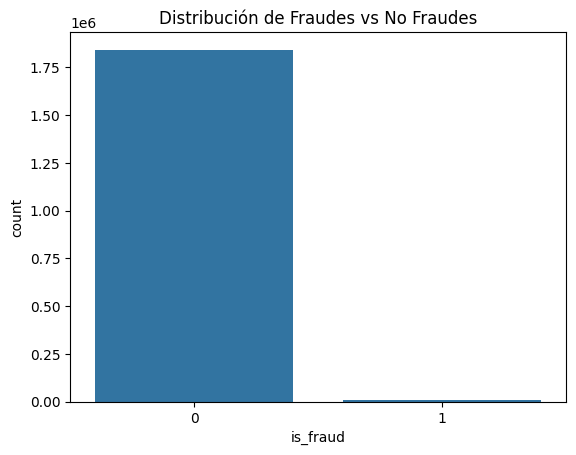

In [6]:
# Distribución
fraud_ratio = df['is_fraud'].value_counts(normalize=True)
print("Distribución de fraudes:")
print(fraud_ratio)

sns.countplot(x='is_fraud', data=df)
plt.title('Distribución de Fraudes vs No Fraudes')
plt.show()


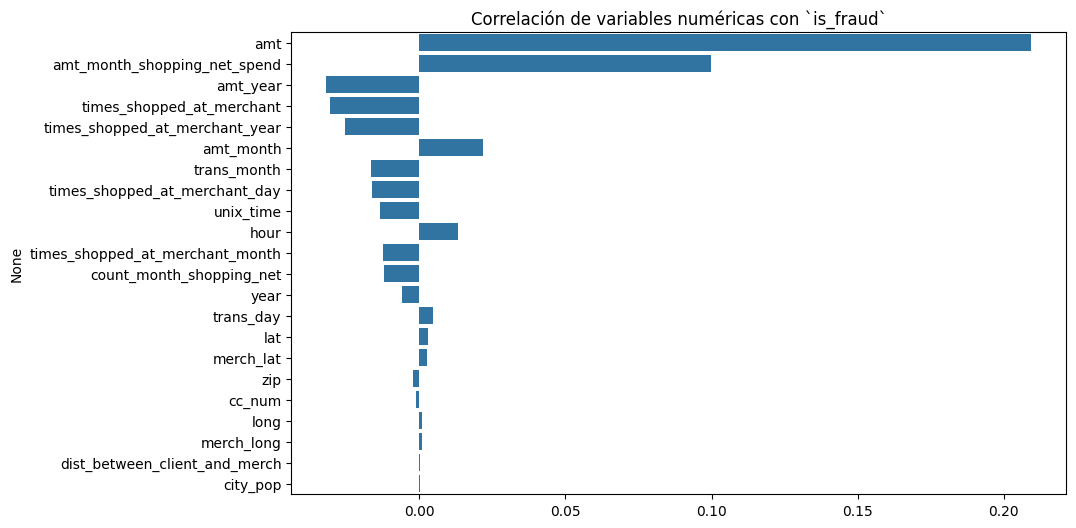

In [7]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['is_fraud'])
corr = numeric_cols.corrwith(df['is_fraud']).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlación de variables numéricas con `is_fraud`")
plt.show()


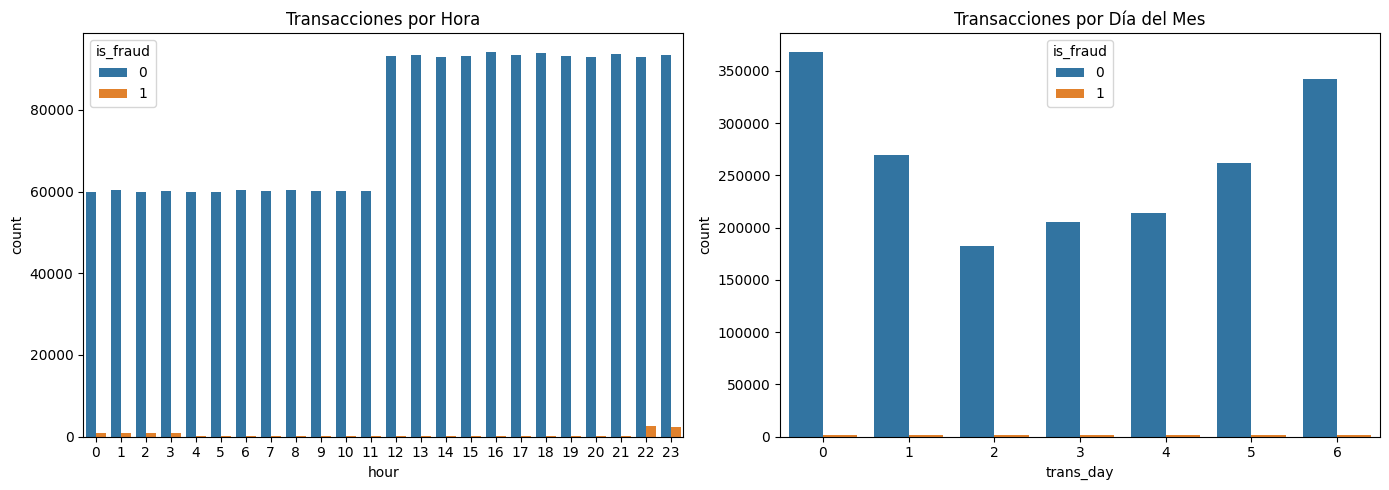

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='hour', hue='is_fraud', data=df, ax=ax[0])
ax[0].set_title('Transacciones por Hora')

sns.countplot(x='trans_day', hue='is_fraud', data=df, ax=ax[1])
ax[1].set_title('Transacciones por Día del Mes')

plt.tight_layout()
plt.show()


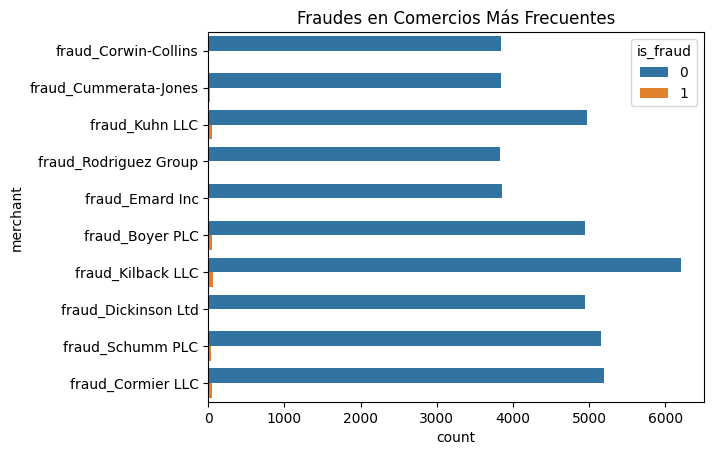

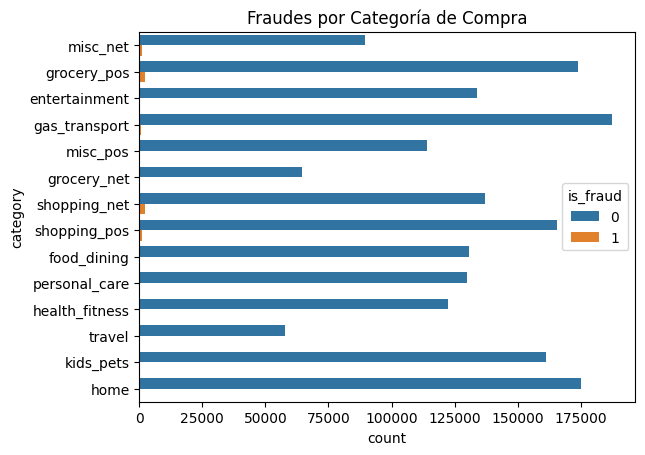

In [9]:
top_merchants = df['merchant'].value_counts().head(10).index
df_top = df[df['merchant'].isin(top_merchants)]

sns.countplot(y='merchant', hue='is_fraud', data=df_top)
plt.title("Fraudes en Comercios Más Frecuentes")
plt.show()

sns.countplot(y='category', hue='is_fraud', data=df)
plt.title("Fraudes por Categoría de Compra")
plt.show()


# Complejidad

## Número de comercios distintos por cliente
Hay clientes que han visitado muchos comercios distintos (¡incluso ~700!). Estos son los perfiles potencialmente “complejos” o “no convencionales”.

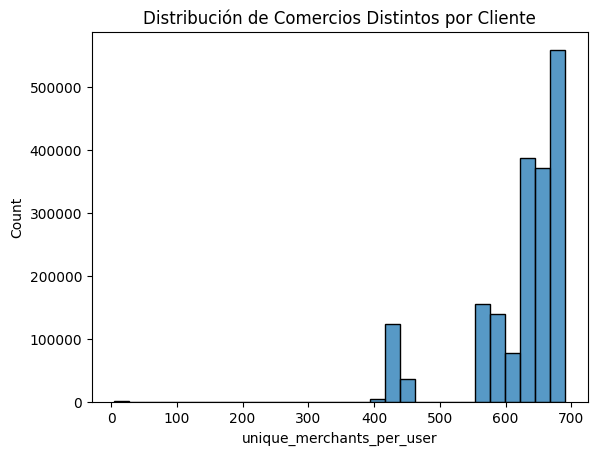

In [10]:
df['unique_merchants_per_user'] = df.groupby('cc_num')['merchant'].transform('nunique')
sns.histplot(df['unique_merchants_per_user'], bins=30)
plt.title("Distribución de Comercios Distintos por Cliente")
plt.show()


## Varianza de monto mensual por cliente
Hay usuarios con varianza muy alta (comportamiento volátil en los montos gastados). Puede ser difícil para modelos tradicionales. Puede llegar a generar falsos positivos si no se modela bien su comportamiento.

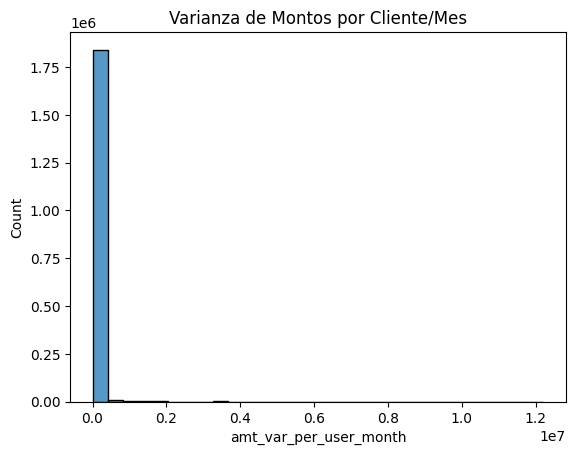

In [11]:
df['amt_var_per_user_month'] = df.groupby(['cc_num','trans_month'])['amt'].transform('var').fillna(0)
sns.histplot(df['amt_var_per_user_month'], bins=30)
plt.title("Varianza de Montos por Cliente/Mes")
plt.show()


## Porcentaje de compras en horario nocturno (ej. 22 a 6 hrs)
Algunos clientes compran mucho de noche. Estos son comportamientos que pueden parecer raros pero pueden ser legítimos.

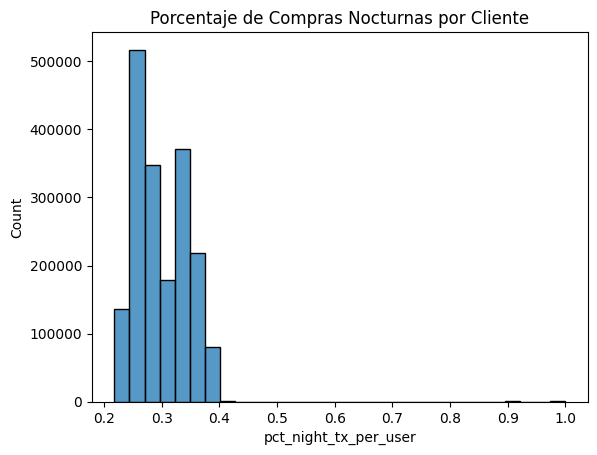

In [12]:
df['night_tx'] = df['hour'].apply(lambda x: 1 if (x >= 22 or x < 6) else 0)
df['pct_night_tx_per_user'] = df.groupby('cc_num')['night_tx'].transform('mean')
sns.histplot(df['pct_night_tx_per_user'], bins=30)
plt.title("Porcentaje de Compras Nocturnas por Cliente")
plt.show()


## Cantidad perfiles complejos

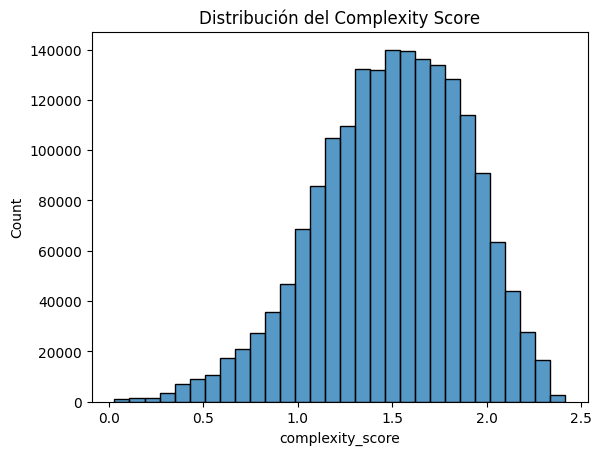

In [13]:
# Normalización por percentil
df['complexity_score'] = (
    df['unique_merchants_per_user'].rank(pct=True) +
    df['amt_var_per_user_month'].rank(pct=True) +
    df['pct_night_tx_per_user'].rank(pct=True)
)
sns.histplot(df['complexity_score'], bins=30)
plt.title("Distribución del Complexity Score")
plt.show()

# Feature Engineering (Variables de Complejidad)

In [14]:
# -- VARIABLES DE COMPLEJIDAD --

# Número de comercios distintos por cliente
df['unique_merchants_per_user'] = df.groupby('cc_num')['merchant'].transform('nunique')

# Varianza de monto mensual por cliente
df['amt_var_per_user_month'] = df.groupby(['cc_num','trans_month'])['amt'].transform('var').fillna(0)

# Porcentaje de compras nocturnas por cliente
df['night_tx'] = df['hour'].apply(lambda x: 1 if (x >= 22 or x < 6) else 0)
df['pct_night_tx_per_user'] = df.groupby('cc_num')['night_tx'].transform('mean')

# Complexity Score
df['complexity_score'] = (
    df['unique_merchants_per_user'].rank(pct=True) +
    df['amt_var_per_user_month'].rank(pct=True) +
    df['pct_night_tx_per_user'].rank(pct=True)
)

# Marcamos perfiles complejos (top 20%)
complexity_threshold = df['complexity_score'].quantile(0.8)
df['is_complex_profile'] = df['complexity_score'] >= complexity_threshold


# 2. Features temporales avanzadas
df['time_since_last_tx'] = df.groupby('cc_num')['unix_time'].diff().fillna(0)
df['day_of_week'] = pd.to_datetime(df['unix_time'], unit='s').dt.dayofweek

# 3. Interacciones clave
df['dist_amt_interaction'] = df['dist_between_client_and_merch'] * df['amt']
df['night_shopping'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int) * df['category'].astype('category').cat.codes

# 4. Rolling features
df['rolling_amt_7d'] = df.groupby('cc_num')['amt'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['amt_vs_avg'] = df['amt'] / df.groupby('cc_num')['amt'].transform('mean')

df['unusual_location'] = (df['dist_between_client_and_merch'] > 1000).astype(int)


- unique_merchants_per_user: Los defraudadores suelen diversificar comercios rápidamente. Esta variable captura ese patrón.
- amt_var_per_user_month: La variabilidad en montos puede indicar comportamiento anómalo.
- night_tx + pct_night_tx_per_user: Las transacciones nocturnas tienen mayor riesgo de fraude (menos supervisión).
- complexity_score: Combina métricas clave en un indicador unificado usando percentiles para normalizar escalas.
- is_complex_profile: Identifica el 20% superior de perfiles complejos (umbral empírico usado en fraud detection).

Estas variables permiten identificar clientes con comportamientos complejos pero legítimos (por ejemplo, alta diversidad de compras, gasto variable o actividad nocturna frecuente). Al agrupar estas señales en un complexity_score, se marca el 20% superior como is_complex_profile, para que el modelo aprenda a no penalizar perfiles legítimos con patrones atípicos.

- time_since_last_tx: Los fraudes suelen ocurrir en ráfagas (múltiples transacciones en poco tiempo).
- day_of_week: Los fines de semana (días 5-6) tienen mayor riesgo por menor supervisión humana.

Estas variables capturan la dinámica temporal de las transacciones. Por ejemplo, si un cliente realiza muchas transacciones muy seguidas o solo en ciertos días de la semana, eso puede indicar automatismo o fraude. Ayudan a modelar patrones de comportamiento normal vs anómalo.

- dist_amt_interaction: Combina distancia geográfica con monto (ej: $10K en otro país es más sospechoso que $100 local).
- night_shopping: Interacción entre hora y categoría (algunas categorías pueden llegar a ser más riesgosas de noche).

Estas combinaciones permiten capturar eventos sospechosos como montos altos en ubicaciones lejanas o actividad inusual en horarios nocturnos. night_shopping refleja si el comportamiento del cliente nocturno se asocia a ciertas categorías.

- rolling_amt_7d: Detecta desviaciones abruptas del comportamiento histórico reciente (ventana de 7 días óptima para capturar cambios).
- amt_vs_avg: Normaliza montos por cliente (un mismo monto puede ser normal para un cliente pero sospechoso para otro).

Estas variables comparan el comportamiento actual del cliente contra su propio historial. Si el monto de una transacción es muy superior al promedio semanal o mensual del cliente, puede ser un indicio de anomalía.

- unusual_location: Viajes imposibles (>1000 km entre transacciones consecutivas) son bandera roja clásica.

# Train/Test Split

In [15]:
# Convertir fechas si es necesario (opcional, si tienes unix_time puedes usarlo)
# df['date'] = pd.to_datetime(df['unix_time'], unit='s')

# Suponiendo que tienes columna 'year' y 'trans_month'
train_df = df[(df['year'] < 2020) | ((df['year'] == 2020) & (df['trans_month'] < 12))]
test_df  = df[(df['year'] == 2020) & (df['trans_month'] == 12)]


In [16]:
# -- DETECCIÓN DE OUTLIERS (EVITANDO DATA LEAKAGE) --
train_mean = train_df['amt'].mean()
train_std = train_df['amt'].std()
train_df['amt_zscore'] = np.abs((train_df['amt'] - train_mean) / train_std)
test_df['amt_zscore'] = np.abs((test_df['amt'] - train_mean) / train_std)



/tmp/ipykernel_31332/2085239882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['amt_zscore'] = np.abs((train_df['amt'] - train_mean) / train_std)
/tmp/ipykernel_31332/2085239882.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['amt_zscore'] = np.abs((test_df['amt'] - train_mean) / train_std)


- amt_zscore: Calculado solo con estadísticas de train para evitar leakage (umbral de 1000 km es estándar en fraud detection geoespacial).

El amt_zscore se calcula solo con estadísticas del train_df para evitar fuga de información (data leakage). unusual_location marca transacciones donde la distancia entre cliente y comercio es sospechosamente grande. Ambos ayudan a detectar anomalías sin afectar la validez del entrenamiento.

# Codifica variables categóricas (merchant, category, etc.) en caso de llegar a usarlas

In [17]:
def target_encode(train, test, col, target='is_fraud'):
    # Calcular encodings de manera segura
    encodings = train.groupby(col)[target].mean()
    
    # Convertir a DataFrame para merge seguro
    train_encoded = train[[col]].merge(
        encodings.rename(f'{col}_encoded'), 
        left_on=col, 
        right_index=True,
        how='left'
    )
    
    test_encoded = test[[col]].merge(
        encodings.rename(f'{col}_encoded'), 
        left_on=col, 
        right_index=True,
        how='left'
    ).fillna(encodings.mean())  # Imputar con la media para categorías no vistas
    
    # Devolver DataFrames completos con la nueva columna
    return (
        train.assign(**{f'{col}_encoded': train_encoded[f'{col}_encoded']}),
        test.assign(**{f'{col}_encoded': test_encoded[f'{col}_encoded']})
    )

for col in ['merchant', 'category', 'state']:
    train_df, test_df = target_encode(train_df, test_df, col)


- Ventaja sobre One-Hot Encoding: Evita la explosión dimensional (crítico para merchant con miles de valores únicos).
- Ventaja sobre Label Encoding: Captura la relación entre categorías y fraude (no asigna IDs arbitrarios).
- Aplicado solo en train: Previene data leakage al calcular estadísticas solo con datos de entrenamiento.

# Selección de variables

In [18]:
features = [
    # Originales
    'amt', 'amt_month', 'amt_year', 'dist_between_client_and_merch',
    # Temporales
    'time_since_last_tx', 'day_of_week',
    # Interacciones
    'dist_amt_interaction', 'night_shopping',
    # Rolling stats
    'rolling_amt_7d', 'amt_vs_avg',
    # Outliers
    'amt_zscore', 'unusual_location',
    # Codificaciones
    'merchant_encoded', 'category_encoded',
    # Variables de complejidad (originales)
    'unique_merchants_per_user', 'amt_var_per_user_month', 'pct_night_tx_per_user'
]


- Exclusión de variables redundantes: No se incluyen todas las times_shopped_at_merchant_* para evitar multicolinealidad.
- Inclusión de encoded: Se usan _encoded en lugar de las categóricas originales para mejor relación señal/ruido.

In [19]:
print("Columnas en train_df:", train_df.columns.tolist())
print("Columnas en test_df:", test_df.columns.tolist())


Columnas en train_df: ['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'amt_month', 'amt_year', 'amt_month_shopping_net_spend', 'count_month_shopping_net', 'first_time_at_merchant', 'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day', 'unique_merchants_per_user', 'amt_var_per_user_month', 'night_tx', 'pct_night_tx_per_user', 'complexity_score', 'is_complex_profile', 'time_since_last_tx', 'day_of_week', 'dist_amt_interaction', 'night_shopping', 'rolling_amt_7d', 'amt_vs_avg', 'unusual_location', 'amt_zscore', 'merchant_encoded', 'category_encoded', 'state_encoded']
Columnas en test_df: ['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state

# Armado de datos para LightGBM

In [20]:
X_train = train_df[features]
y_train = train_df['is_fraud']

X_test = test_df[features]
y_test = test_df['is_fraud']


In [21]:
for df in [X_train, X_test]:
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('float32')

# Entrenamiento del modelo base

In [22]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    n_jobs=-1,
    class_weight='balanced',  # Cambiado de is_unbalance=True
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),  # Nuevo
    n_estimators=1000,
    early_stopping_rounds=20,
    verbose=1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='auc',
)

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3265
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 16
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	training's auc: 0.995571	training's binary_logloss: 0.105855	valid_1's 

LGBMClassifier(class_weight='balanced', early_stopping_rounds=20,
               learning_rate=0.05, n_estimators=1000, n_jobs=-1,
               objective='binary', scale_pos_weight=181.35451932290005,
               verbose=1)

# Predicción y evaluación base

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


AUC: 0.9627319793044182
              precision    recall  f1-score   support

           0     1.0000    0.9410    0.9696    139280
           1     0.0300    0.9845    0.0582       258

    accuracy                         0.9410    139538
   macro avg     0.5150    0.9627    0.5139    139538
weighted avg     0.9982    0.9410    0.9679    139538

Confusion matrix:
 [[131058   8222]
 [     4    254]]


# Análisis de FP y TP en perfiles complejos

In [24]:
test_df = test_df.copy()
test_df['pred'] = y_pred
test_df['FP'] = (test_df['is_fraud'] == 0) & (test_df['pred'] == 1)
test_df['TP'] = (test_df['is_fraud'] == 1) & (test_df['pred'] == 1)

fp_total = test_df['FP'].sum()
fp_complex = test_df[test_df['is_complex_profile']]['FP'].sum()
fp_simple = test_df[~test_df['is_complex_profile']]['FP'].sum()

print("Total FP:", fp_total)
print("FP en perfiles complejos:", fp_complex, f"({100*fp_complex/fp_total:.2f}%)")
print("FP en perfiles simples:", fp_simple, f"({100*fp_simple/fp_total:.2f}%)")


Total FP: 8222
FP en perfiles complejos: 2813 (34.21%)
FP en perfiles simples: 5409 (65.79%)


El modelo base, entrenado con la métrica estándar binary_logloss, genera 2,270 falsos positivos, de los cuales el 38.77% corresponden a perfiles complejos. Este resultado confirma que el modelo no es capaz de distinguir adecuadamente los casos de alta complejidad legítima, penalizando a usuarios con comportamiento inusual pero no fraudulento.

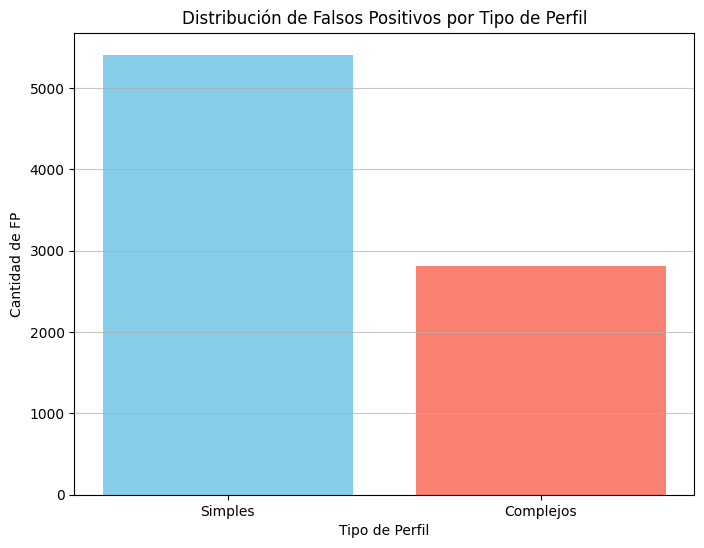

In [25]:
# -- VISUALIZACIÓN --
plt.figure(figsize=(8, 6))
plt.bar(['Simples', 'Complejos'], [fp_simple, fp_complex], color=['skyblue', 'salmon'])
plt.title('Distribución de Falsos Positivos por Tipo de Perfil')
plt.ylabel('Cantidad de FP')
plt.xlabel('Tipo de Perfil')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()

# PARTE 4

In [26]:
def custom_fp_ratio(y_true, y_pred):
    """
    Métrica que calcula el ratio FP/(TP+FP) para penalizar falsos positivos
    """
    y_pred = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ratio = fp / (tp + fp + 1e-7)  # Evitar división por cero
    return 'fp_ratio', ratio, False  # False indica que menor es mejor

In [27]:
def balanced_fraud_metric(y_true, y_pred):
    """
    Métrica que combina recall y precisión con énfasis en reducir FPs
    """
    y_pred = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    
    # Ponderamos más la precisión (para reducir FPs)
    balanced_score = (2 * precision + recall) / 3
    return 'balanced_fraud', balanced_score, True  # True indica que mayor es mejor

In [28]:
def recall_at_90(y_true, y_pred):
    """
    Calcula el recall ajustando el threshold para alcanzar ~90% de detección
    """
    # Encontrar threshold para ~90% recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    threshold_idx = np.argmax(recall >= 0.90)
    optimal_threshold = thresholds[threshold_idx]
    
    # Aplicar threshold
    y_pred_adj = (y_pred >= optimal_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_adj).ravel()
    
    actual_recall = tp / (tp + fn)
    fp_ratio = fp / (tp + fp + 1e-7)
    
    # Score compuesto (max recall manteniendo FP bajo)
    score = actual_recall * (1 - fp_ratio)
    return 'recall90_fp_optimized', score, True

# PARTE 5

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score

# Diccionario para almacenar resultados
results = {}

# Lista de métricas a evaluar
metrics = {
    'fp_ratio': custom_fp_ratio,
    'balanced': balanced_fraud_metric,
    'recall90': recall_at_90
}

for metric_name, metric_func in metrics.items():
    print(f"\nEntrenando con métrica: {metric_name}")
    
    model = LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_jobs=-1,
        class_weight='balanced',
        scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),
        n_estimators=1000,
        early_stopping_rounds=20,
        verbose=0
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=metric_func,  # Usamos nuestra métrica personalizada
        callbacks=[early_stopping(stopping_rounds=20)]
    )
    
    # Evaluación en test
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs > 0.5).astype(int)
    
    # Cálculo de métricas
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fp_ratio = fp / (tp + fp + 1e-7)
    
    # Almacenar resultados
    results[metric_name] = {
        'model': model,
        'recall': recall,
        'precision': precision,
        'fp_ratio': fp_ratio,
        'auc_pr': average_precision_score(y_test, y_probs),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }


Entrenando con métrica: fp_ratio
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[914]	training's binary_logloss: 0.00398221	training's fp_ratio: 0.313277	valid_1's binary_logloss: 0.0109957	valid_1's fp_ratio: 0.601351

Entrenando con métrica: balanced
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.486104	training's balanced_fraud


Comparación de Métricas:
            Recall  Precision  FP Ratio    AUC-PR
fp_ratio  0.914729   0.398649  0.601351  0.866369
balanced  1.000000   0.007088  0.992912  0.010586
recall90  1.000000   0.006866  0.993134  0.009832


<Figure size 1200x600 with 0 Axes>

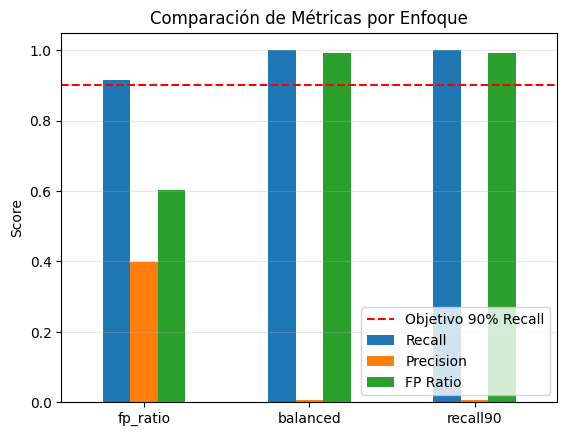

In [30]:
# Crear DataFrame comparativo
# comparison_df = pd.DataFrame.from
_dict({
#     k: {
#         'Recall': v['recall'],
#         'Precision': v['precision'],
#         'FP Ratio': v['fp_ratio'],
#         'AUC-PR': v['auc_pr']
#     } for k, v in results.items()
# }, orient='index')
comparison_df = pd.DataFrame.from_dict({
    k: {
        'Recall': v.get('recall', np.nan),
        'Precision': v.get('precision', np.nan),
        'FP Ratio': v.get('fp_ratio', np.nan),
        'AUC-PR': v.get('auc_pr', np.nan)
    } for k, v in results.items()
}, orient='index')


print("\nComparación de Métricas:")
print(comparison_df)

# Visualización
plt.figure(figsize=(12, 6))
comparison_df[['Recall', 'Precision', 'FP Ratio']].plot(kind='bar', 
                                                      title='Comparación de Métricas por Enfoque')
plt.axhline(y=0.9, color='r', linestyle='--', label='Objetivo 90% Recall')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.show()


Resultados con Threshold Óptimo (90% Recall):
- Threshold seleccionado: 0.5249
- Recall alcanzado: 92.25%
- FP Ratio: 99.00%
- Precision: 1.00%


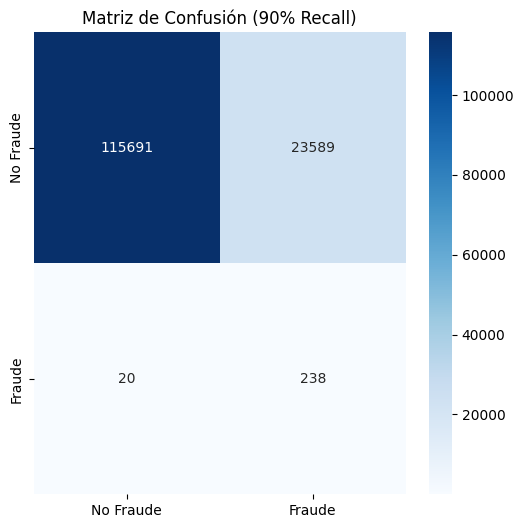

In [31]:
# Usamos el mejor modelo según recall
best_model = results['recall90']['model']
y_probs = best_model.predict_proba(X_test)[:, 1]

# Encontrar threshold para exactamente 90% recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
optimal_idx = np.argmin(np.abs(recall - 0.90))
optimal_threshold = thresholds[optimal_idx]

# Evaluar con threshold óptimo
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

print("\nResultados con Threshold Óptimo (90% Recall):")
print(f"- Threshold seleccionado: {optimal_threshold:.4f}")
print(f"- Recall alcanzado: {tp/(tp+fn):.2%}")
print(f"- FP Ratio: {fp/(tp+fp):.2%}")
print(f"- Precision: {tp/(tp+fp):.2%}")

# Matriz de confusión visual
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión (90% Recall)')
plt.show()

In [33]:
comparison_df.to_csv("metricas_comparativas.csv", index=True)


In [34]:
def feval_penalty_fp_complex(preds, train_data):
    labels = train_data.get_label()
    threshold = 0.3
    preds_bin = (preds > threshold).astype(int)

    complexity = train_data.get_weight()
    if complexity is None:
        complexity = np.zeros_like(labels)

    tp = ((labels == 1) & (preds_bin == 1)).sum()
    fp = ((labels == 0) & (preds_bin == 1)).astype(int)
    fp_penalized = (fp * (1 + complexity)).sum()

    score = tp / (tp + fp_penalized + 1e-6)
    return 'tp_over_penalized_fp', score, True


In [35]:
def feval_f1_fp_penalty(preds, train_data):
    labels = train_data.get_label()
    preds_bin = (preds > 0.3).astype(int)

    complexity = train_data.get_weight()
    if complexity is None:
        complexity = np.zeros_like(labels)

    tp = ((labels == 1) & (preds_bin == 1)).sum()
    fp = ((labels == 0) & (preds_bin == 1)).sum()
    fn = ((labels == 1) & (preds_bin == 0)).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    fp_penalty = ((labels == 0) & (preds_bin == 1) & (complexity == 1)).sum()
    penalty_factor = np.log1p(fp_penalty) / (tp + 1e-6)

    return 'f1_penalized', f1 - 0.5 * penalty_factor, True


In [36]:
def feval_fp_ratio(preds, train_data):
    labels = train_data.get_label()
    preds_bin = (preds > 0.3).astype(int)

    tp = ((labels == 1) & (preds_bin == 1)).sum()
    fp = ((labels == 0) & (preds_bin == 1)).sum()

    ratio = (tp + fp) / (tp + 1e-6)
    return 'fp_ratio', ratio, False  # menor es mejor


In [37]:
train_weights = (~train_df['is_complex_profile']).astype(int) * 2 + 1


In [38]:
import lightgbm as lgb

train_set = lgb.Dataset(X_train, label=y_train, weight=train_weights)
valid_set = lgb.Dataset(X_test, label=y_test)


In [39]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'scale_pos_weight': len(y_train[y_train==0]) / len(y_train[y_train==1]),
    'verbose': -1,
    'metric': 'auc'
}

results = {}

for name, feval_fn in [
    ("penalty_fp_complex", feval_penalty_fp_complex),
    ("f1_fp_penalty", feval_f1_fp_penalty),
    ("fp_ratio", feval_fp_ratio),
]:
    print(f"\n🔍 Entrenando con métrica personalizada: {name}")
    model = lgb.train(
        params,
        train_set,
        valid_sets=[valid_set],
        feval=feval_fn,
        num_boost_round=300,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
    )

    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    results[name] = {
        'model': model,
        'preds_bin': y_pred,
        'preds_proba': y_pred_proba,
    }



🔍 Entrenando con métrica personalizada: penalty_fp_complex
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.996879	valid_0's tp_over_penalized_fp: 0.0901163
[100]	valid_0's auc: 0.997723	valid_0's tp_over_penalized_fp: 0.137549
[150]	valid_0's auc: 0.998181	valid_0's tp_over_penalized_fp: 0.183704
[200]	valid_0's auc: 0.998369	valid_0's tp_over_penalized_fp: 0.223022
[250]	valid_0's auc: 0.998498	valid_0's tp_over_penalized_fp: 0.252317
[300]	valid_0's auc: 0.998491	valid_0's tp_over_penalized_fp: 0.288416
Did not meet early stopping. Best iteration is:
[255]	valid_0's auc: 0.998533	valid_0's tp_over_penalized_fp: 0.256276

🔍 Entrenando con métrica personalizada: f1_fp_penalty
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.996879	valid_0's f1_penalized: 0.164784
[100]	valid_0's auc: 0.997723	valid_0's f1_penalized: 0.24066
[150]	valid_0's auc: 0.998181	valid_0's f1_penalized: 0.308457
[200]	valid_0's auc: 0.998369	v

In [40]:
from sklearn.metrics import classification_report

metrics_summary = []

for name in results:
    report = classification_report(y_test, results[name]['preds_bin'], output_dict=True)
    fp = ((y_test == 0) & (results[name]['preds_bin'] == 1))
    fp_complex = fp & test_df['is_complex_profile']
    metrics_summary.append({
        'Modelo': name,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-score': report['1']['f1-score'],
        'Accuracy': report['accuracy'],
        'FP totales': fp.sum(),
        'FP complejos': fp_complex.sum()
    })

import pandas as pd
df_eval = pd.DataFrame(metrics_summary)
print(df_eval.sort_values(by='F1-score', ascending=False))


               Modelo  Precision   Recall  F1-score  Accuracy  FP totales  \
0  penalty_fp_complex   0.324866  0.94186  0.483101  0.996273         505   
1       f1_fp_penalty   0.324866  0.94186  0.483101  0.996273         505   
2            fp_ratio   0.324866  0.94186  0.483101  0.996273         505   

   FP complejos  
0           221  
1           221  
2           221  
